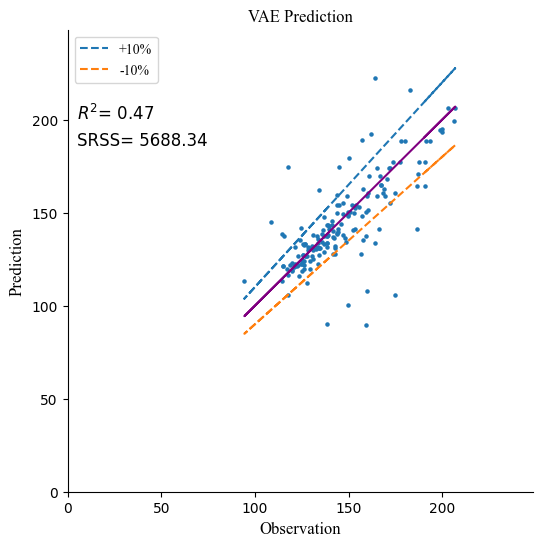

In [10]:
# #模型6(Probability neural network)######################## 
import tensorflow as tf
import tensorflow_probability as tfp
tfd = tfp.distributions
import numpy as np
from numpy.polynomial.polynomial import polyfit
from sklearn import linear_model
from sklearn.model_selection import KFold
from sklearn.metrics import r2_score
import pandas as pd
import matplotlib.pyplot as plt
# if tf.test.gpu_device_name() != '/device:GPU:0':
#   print('WARNING: GPU device not found.')
# else:
#   print('SUCCESS: Found GPU: {}'.format(tf.test.gpu_device_name()))

#读入数据
df = pd.read_excel('C:/Users/Tongrui/Desktop/UHPC1.xlsx')
df= df.dropna()
# df = df.sort_values(by=df.columns[11],ascending=False)
RawD=(df.iloc[:,:12].values).astype(np.float64)
permuted_indices = np.random.permutation(RawD.shape[0])
RawD = RawD[permuted_indices]
TrainD= RawD[:int(RawD.shape[0] * 0.8)]
TestD = RawD[int(RawD.shape[0] * 0.8):]

xT=TrainD[:,:11]
yT=TrainD[:,11]

x=TestD[:,:11]
y=TestD[:,11]
y_up=y*1.1
y_down=y*0.9

def prior6A(kernel_size,bias_size,dtype=None):  #untrainable
    n = kernel_size + bias_size 
    loc=[]
    scale=[]
    for i in range(kernel_size):
        loc.append(0.01)
        scale.append(0.05)
    for j in range(bias_size):
        loc.append(0.01)   
        scale.append(0.05)
    return tf.keras.Sequential([
                   tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=loc, scale=scale))) 
                              ])

def posterior6A(kernel_size, bias_size, dtype=None):#后验为多维独立正态分布
    n = kernel_size + bias_size
    return tf.keras.Sequential([
                   tfp.layers.VariableLayer(2 * n, dtype=dtype), 
                   tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[..., :n], scale=1e-3 +0.001* tf.math.softplus(0.01 * t[..., n:]))))
                              ])


def prior6B(kernel_size,bias_size, dtype=None): #trainable
    n = kernel_size + bias_size 
    return tf.keras.Sequential([
                   tfp.layers.VariableLayer(n, dtype=dtype),
                   tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t, scale=1e-3 +0.001* tf.math.softplus(0.01 * t)), reinterpreted_batch_ndims=1)),
                              ])

def posterior6B(kernel_size, bias_size, dtype=None):#后验为多维联合正态分布
    n = kernel_size + bias_size
    return tf.keras.Sequential([
                  tfp.layers.VariableLayer(
                  tfp.layers.MultivariateNormalTriL.params_size(n), dtype=dtype
                                             ),
                  tfp.layers.MultivariateNormalTriL(n),
                              ])

model6=tf.keras.Sequential([
       tf.keras.layers.Input(shape=(11,)),#输入的维度，即每个samples的feature数
       tf.keras.layers.Dense(64,activation='relu'),
       tf.keras.layers.Dense(128,activation='relu'), 
       tf.keras.layers.Dense(32,activation='relu'), 
       tf.keras.layers.Dense(8,activation='relu'), 
       tfp.layers.DenseVariational(
                              units = 2, 
                              make_prior_fn = prior6B, 
                              make_posterior_fn = posterior6B, 
                              kl_weight=1/len(x)
                             ), 
       tfp.layers.DistributionLambda(lambda t: tfd.Independent(tfd.Normal(loc=t[..., :1], scale=1e-3 + tf.math.softplus(0.01 * t[..., 1:]))))
                            ])

negloglik = lambda y, p_y: -p_y.log_prob(y)
model6.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01),loss=negloglik)
model6.fit(xT,yT,epochs=10000,verbose=0,validation_split=0.2)
loss, accuracy = model6.evaluate(xT, yT)
py6=model6(x).mean()
std6=model6(x).variance()

r_squared = r2_score(y,py6)
srss = np.sqrt(np.sum((y-py6)**2)/len(y))

plt.figure(figsize=(6, 6))
plt.title('VAE Prediction',font='times new roman',fontsize=12)
plt.axis([0, 1.2*np.max(y), 0,  1.2*np.max(y)])
plt.xlabel('Observation',font='times new roman',fontsize=12)
plt.xticks(font='times new roman',fontsize=12)
plt.ylabel('Prediction',font='times new roman',fontsize=12)
plt.yticks(font='times new roman',fontsize=12)
plt.gca().spines["right"].set_color("none")
plt.gca().spines["top"].set_color("none")
plt.gca().spines["bottom"].set_position(("data", 0))
plt.gca().spines["left"].set_position(("data", 0))
plt.plot(y, y_up, label='+10%',linestyle='--')#模型6（Gaussion）
plt.plot(y, y, linestyle='-', color='purple')
plt.plot(y, y_down, label='-10%',linestyle='--')#模型6（Gaussion）
plt.scatter(y,py6,s=5)
plt.text(5, 210, "Loss= %.2f" % loss,font='times new roman',fontsize=12)
plt.text(5, 195, "Max std= %.2f" % maxstd,font='times new roman',fontsize=12)
plt.text(5, 180, "$R^{2}$= %.2f" % r_squared,font='times new roman',fontsize=12)
plt.text(5, 165, "SRSS= %.2f" % srss,font='times new roman',fontsize=12)
plt.legend(loc='upper left',prop='times new roman',fontsize=12)
plt.savefig('C:/Users/Tongrui/Desktop/2.jpeg')
plt.show()
